## Comparison between theory and simulations for curriculum learning

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from numpy.random import normal
from scipy.special import erf
from tqdm import tqdm

## Theory

In [2]:
def Power(x,i):
    return x**i
def Sqrt(x):
    return np.sqrt(x)
def ArcSin(x):
    return np.arcsin(x)
def ArcCos(x):
    return np.arccos(x)
def Abs(x):
    return np.abs(x)
Pi=np.pi

In [3]:
def compute_generalization_theory(x,T,Delta1,Delta2,p1):
    Qr,Qi,R = x

    return p1*ArcCos(R/Sqrt((Delta1*Qi + Qr)*T))/Pi+(1-p1)*ArcCos(R/Sqrt((Delta2*Qi + Qr)*T))/Pi

In [4]:
def compute_update_theory(x, eta,lamb, T, Delta):
    Qr,Qi,  R = x
    
    fQr=-lamb*Qr+(4*eta*(-(Qr/Sqrt(1+Delta*Qi+Qr))+((2+Delta*Qi)*R)/Sqrt(-Power(R,2)+(2+Delta*Qi+Qr)*T)))/(Pi*(2+Delta*Qi+Qr))+(2*Power(eta,2)*(Pi/2.+ArcSin((Delta*Qi+Qr)/(2+3*Delta*Qi+3*Qr))-2*ArcSin(R/(Sqrt(2+3*Delta*Qi+3*Qr)*Sqrt(-Power(R,2)+(1+Delta*Qi+Qr)*T)))))/(Power(Pi,2)*Sqrt(1+Delta*Qi+Qr))
    
    fQi=-lamb*Qi+(-4*Delta*eta*Qi*(1/Sqrt(1+Delta*Qi+Qr)+R/Sqrt(-Power(R,2)+(2+Delta*Qi+Qr)*T)))/(Pi*(2+Delta*Qi+Qr))+(2*Delta*Power(eta,2)*(Pi/2.+ArcSin((Delta*Qi+Qr)/(2+3*Delta*Qi+3*Qr))-2*ArcSin(R/(Sqrt(2+3*Delta*Qi+3*Qr)*Sqrt(-Power(R,2)+(1+Delta*Qi+Qr)*T)))))/(Power(Pi,2)*Sqrt(1+Delta*Qi+Qr))
    
    fR=-lamb*R/2+(2*eta*(-(R/Sqrt(1+Delta*Qi+Qr))+Sqrt(-Power(R,2)+(2+Delta*Qi+Qr)*T)))/(Pi*(2+Delta*Qi+Qr))
    
    return np.array([fQr, fQi, fR])


In [5]:
def integrate_forward(xs,errors,etas,lambs,Deltas,epochs,dt,Delta1,Delta2,p1,T):
    # Euler method
    errors[0]=compute_generalization_theory(xs[0],T,Delta1,Delta2,p1)
    for a in range(epochs):
        xs[a+1]=xs[a]+dt*compute_update_theory(xs[a], etas[a],lambs[a], T, Deltas[a])
        errors[a+1]=compute_generalization_theory(xs[a+1],T,Delta1,Delta2,p1)
    return xs, errors

## Simulations

In [6]:
def generate_data(N,num_samples,Delta,wt):
    Drel=int(N)
    Dirr=int(N)
    
    if num_samples==1:
        # We introduce the correct scaling into the data
        xr=normal(0.,1.,size=(Drel))
        xi=np.sqrt(Delta)*normal(0.,1.,size=(Dirr))
    else:
        # We introduce the correct scaling into the data
        xr=normal(0.,1.,size=(num_samples,Drel))
        xi=np.sqrt(Delta)*normal(0.,1.,size=(num_samples,Dirr))
    
    x=[xr,xi]
    y=np.sign(xr@wt)
    
    return x,y

In [7]:
def sigma(xx, activation="erf"):
    if activation == "erf":
        return erf(xx)
        
    elif activation == "linear":
        return xx

In [8]:
def Dsigma(xx, activation="erf"):
    if activation == "erf":
        return 2*np.exp(-xx**2)/np.sqrt(np.pi)
        
    elif activation == "linear":
        return 1

In [9]:
def compute_gradient_sim(wr,wi,xr,xi,y,lamb,activation="erf"):
    lbdar=xr@wr
    lbdai=xi@wi
    error=sigma((lbdar+lbdai)/2, activation)-y
    dsig=Dsigma((lbdar+lbdai)/2, activation)/2
    return [error*xr*dsig+2*lamb*wr,error*xi*dsig+2*lamb*wi]

In [10]:
def compute_generalization_sim(wr,wi,Xtestr,Xtesti,Ytest,N):
    Ypred=np.sign((Xtestr@wr+Xtesti@wi)/2)
    return np.mean((Ypred-Ytest)**2)/4

In [11]:
def simulate(N,Deltas,Delta1,Delta2,lamb,etas,wr0,wi0,wt,epochs,p1=0.5,activation="erf",test_samples=10000,downsampling=100):
    
    wr=np.zeros(N)
    wi=np.zeros(N)
    wr=wr0
    wi=wi0
    
    errors=np.zeros(epochs//downsampling)

    Qs=np.zeros((epochs//downsampling,3))
    Xtest1,Ytest1=generate_data(N,round(p1*test_samples),Delta1,wt)
    Xtest2,Ytest2=generate_data(N,round((1-p1)*test_samples),Delta2,wt)
    Xtestr1,Xtesti1=Xtest1
    Xtestr2,Xtesti2=Xtest2
    Xtestr=np.concatenate((Xtestr1,Xtestr2),0)
    Xtesti=np.concatenate((Xtesti1,Xtesti2),0)
    Ytest=np.concatenate((Ytest1,Ytest2),0)
    
    

    count=0
    for a in tqdm(range(epochs-1)):
        x,y=generate_data(N,1,Deltas[a],wt)
        [xr,xi]=x
        
        grad=compute_gradient_sim(wr,wi,xr,xi,y,lamb,activation)
        [gradr,gradi]=grad
        
        wr=wr-etas[a]*gradr/N
        wi=wi-etas[a]*gradi/N
        
        if a%downsampling==0:
            errors[count]=compute_generalization_sim(wr,wi,Xtestr,Xtesti,Ytest,N)
            #print("step={} done! Gradient={}".format(a,np.linalg.norm(grad)))
            R=np.dot(wr,wt)
            Qr=np.dot(wr,wr)
            Qirr=np.dot(wi,wi)
            Qs[count]=np.array([Qr,Qirr,R])
            count=count+1
        
    return errors,Qs

### Check simulations

In [12]:
alphaF=5 #total training time
N=30000 #input size
activation="erf"
lamb=0 #regularization
eta=3 #learning rate
Delta1=0 #easy noise level
Delta2=2 #hard noise level
epochs=int(alphaF*N)
downsampling=1000
p1=0.5 #fraction of easy examples
dt=1/N

#### Weight initialization

In [13]:
np.random.seed(195)

In [14]:
wr0=normal(0.,1.,size=(N,))/np.sqrt(N)
wi0=normal(0.,1.,size=(N,))/np.sqrt(N)
wt=np.ones((N,))/np.sqrt(N)


#### Parameters

In [15]:
etas=np.ones(epochs+1)*eta
lambs=np.ones(epochs+1)*lamb

#### Initialize theory overlaps

In [16]:
R=np.dot(wr0,wt)
Qr=np.dot(wr0,wr0)
Qirr=np.dot(wi0,wi0)
T=np.dot(wt,wt)
xs=np.zeros((epochs+1,3))
xs[0]=np.array([Qr,Qirr,R])

In [18]:
Deltas=np.ones(epochs)*Delta2
Deltas[int(epochs/2):]=Delta1

In [19]:
errors_th=np.zeros(epochs+1)

In [20]:
#integrate theory ODEs
xs,errors_th=integrate_forward(xs,errors_th,etas,lambs,Deltas,epochs,dt,Delta1,Delta2,p1,T)

In [21]:
#run simulations
errors_sim_avg=np.zeros(epochs//downsampling)
nseeds=1
for seed in range(nseeds):
    errors_sim,Qs=simulate(N,Deltas,Delta1,Delta2,lamb,etas,wr0,wi0,wt,epochs,p1,downsampling=downsampling)
    errors_sim_avg+=errors_sim/nseeds


100%|██████████| 149999/149999 [03:48<00:00, 656.41it/s]


In [22]:
alphas_sim=np.linspace(0,alphaF,epochs//downsampling)
alphas_th=np.linspace(0,alphaF,len(errors_th))

### Comparison

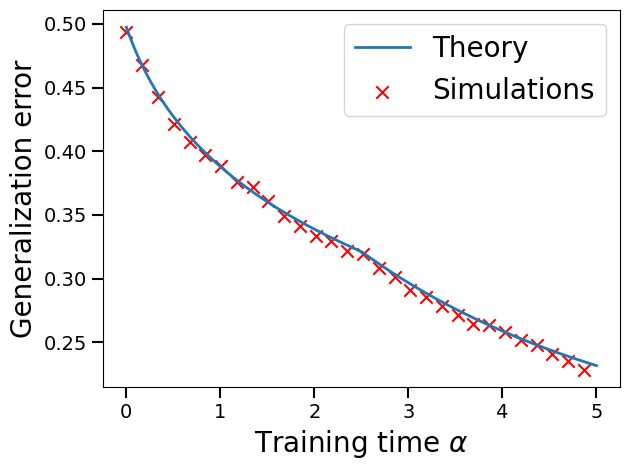

In [23]:
plt.plot(alphas_th,errors_th,label="Theory",lw=2)
plt.scatter(alphas_sim[::5],errors_sim_avg[::5],label="Simulations",marker='x',s=80,color='r',)
plt.legend(fontsize=20)
plt.ylabel("Generalization error",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width
plt.tight_layout()
plt.savefig("thVSsim.pdf")

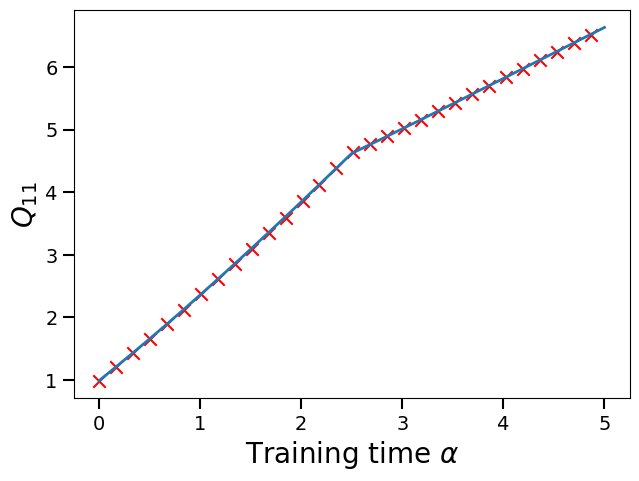

In [25]:
plt.plot(alphas_th,xs[:,0],label="Theory",lw=2)
plt.scatter(alphas_sim[::5],Qs[::5,0],label="Simulations",marker='x',s=80,color='r')
plt.ylabel(r"$Q_{11}$",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width
plt.savefig("Q11thVSsim.pdf")

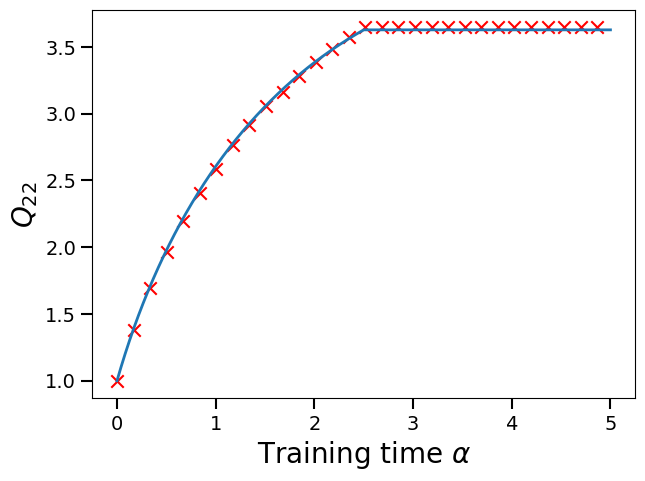

In [26]:
plt.plot(alphas_th,xs[:,1],label="Theory",lw=2)
plt.scatter(alphas_sim[::5],Qs[::5,1],label="Simulations",marker='x',s=80,color='r')
plt.ylabel(r"$Q_{22}$",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width

plt.savefig("Q22thVSsim.pdf")

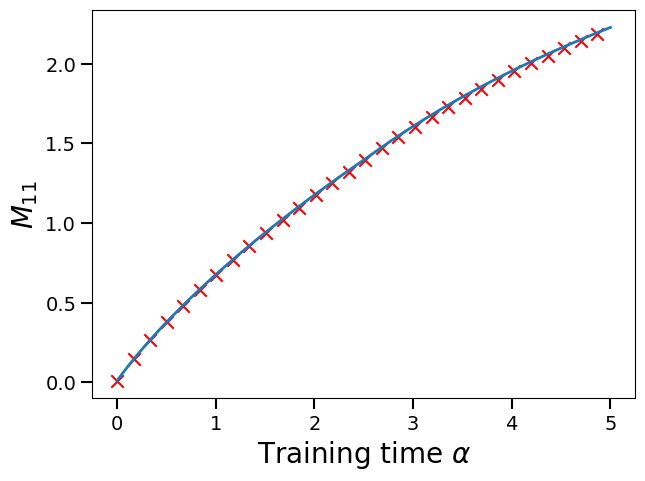

In [27]:
plt.plot(alphas_th,xs[:,2],label="Theory",lw=2)
plt.scatter(alphas_sim[::5],Qs[::5,2],label="Simulations",marker='x',s=80,color='r')
plt.ylabel(r"$M_{11}$",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width
plt.savefig("MthVSsim.pdf")